In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import Dependencies

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from string import punctuation
import tensorflow as tf
import numpy as np
from pickle import dump

# Import Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/GargPriyanshu1112/Image-Caption-Generator/main/helper_functions.py

from helper_functions import get_sample 

--2022-08-06 07:14:49--  https://raw.githubusercontent.com/GargPriyanshu1112/Image-Caption-Generator/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105 (1.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   1.08K  --.-KB/s    in 0s      

2022-08-06 07:14:49 (58.6 MB/s) - ‘helper_functions.py’ saved [1105/1105]



# Setting up Paths

In [ ]:
IMAGES_DIRPATH = "/content/drive/MyDrive/Project/images"
CAPTION_FILEPATH = "/content/drive/MyDrive/Project/captions/Flickr8k.token.txt"

# Get the Contents of the File

In [ ]:
def read_file(filepath):
    # Open the file as read only
    file = open(filepath, mode='r')
    
    # Read the contents of the file
    content = file.read()
    
    # Close the file
    file.close()
    
    return content 

In [ ]:
# Get the content of "Flickr8k.token.txt"
content = read_file(CAPTION_FILEPATH)
content[:1000]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

# Get Image Names and Corresponding Captions

In [ ]:
def sep_image_name_and_captions(content):   
    mappings = dict() # Dictionary to store image name and the corresponding captions
    
    lines = content.split('\n')
    for line in lines:
        if len(line) < 1:
            continue
        image_id, caption = line.split('\t')
        if image_id[:-2] not in mappings:
            mappings[image_id[:-2]] = [caption]
        else:
            mappings[image_id[:-2]].append(caption)
    return mappings


IMAGE:   3357937209_cf4a9512ac.jpg


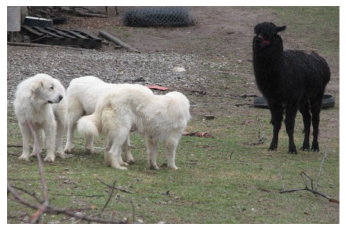


CAPTIONS:

1.  A black sheep with three white dogs .
2.  four white dogs are standing beside a black sheep .
3.  The white dogs look curiously at the black llama .
4.  Three white dogs are near a black llama .
5.  White dogs stand near a sheep or llama .


In [ ]:
# Get image names and the corresponding captions
mappings = sep_image_name_and_captions(content)

# Get sample image and its captions
get_sample(mappings, IMAGES_DIRPATH)

# Preprocess Captions

In [ ]:
def preprocess_text(mappings):
    for image_name, captions_list in mappings.items():
        for idx, caption in enumerate(captions_list):
            # Convert alphabets to lowercase
            text = caption.lower()
            
            # Remove the punctuations
            text = ''.join([char  for char in text  if char not in punctuation])
            
            # Remove words containing numbers and single letters (such as 'a')
            text = [word  for word in text.split()  if (word.isalpha() and len(word)>1)]
            
            # Add start and end tags
            text = "<startseq> " + ' '.join(text) + " <endseq>"
            
            # Replace the original caption with the preprocessed caption
            mappings[image_name][idx] = text
            
    return mappings


IMAGE:   3549006919_3604bc813e.jpg


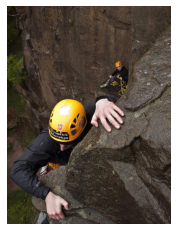


CAPTIONS:

1.  <startseq> man in yellow helmet climbs up rock cliff <endseq>
2.  <startseq> man wearing yellow helmet climbing the side of large rock wall <endseq>
3.  <startseq> man wearing yellow helmet tries to climb rock with his hands <endseq>
4.  <startseq> mountain climber reaches the top of cliff <endseq>
5.  <startseq> person wearing yellow helmet is climbing cliff <endseq>


In [ ]:
# Get mappings with preprocessed captions
mappings_new = preprocess_text(mappings)

# Get sample image and its captions
get_sample(mappings_new, IMAGES_DIRPATH)

# Save Image Names and Corresponding Preprocessed Captions

In [ ]:
def save_mappings(mappings, filename):
    lines = []
    for image_name, captions_list in mappings.items():
        for caption in captions_list:
            lines.append(image_name + '\t' + caption)
    data = '\n'.join(lines)
    
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
# save mappings
save_mappings(mappings_new, 'mappings.txt')

# Preprocess Images

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Model

In [ ]:
def extract_image_features(IMAGES_DIR):
    # Load the model
    model = InceptionV3()
    # Restructure the model (remove the last layer)
    model = Model(inputs=model.input, outputs=model.layers[-2].output)
    
    # Extract features from each image
    features = dict() # Will store features extracted from each image
    for image_name in os.listdir(IMAGES_DIR):
        # Get image path
        image_path = os.path.join(IMAGES_DIR, image_name)
        # Get image
        image = load_img(image_path, target_size=(299, 299))
        # Get image in array form
        input_arr = img_to_array(image)
        # Reshape input image array
        input_arr = np.expand_dims(input_arr, axis=0)
        # Prepare the image for VGG model
        input_arr = preprocess_input(input_arr)
        # Get features
        feature = model.predict(input_arr, verbose=0)
        # Store features
        features[image_name] = feature
        
    return features 

In [ ]:
# Get image features
features = extract_image_features(IMAGES_DIRPATH)

# Save to file
dump(features, open('features.pkl', 'wb'))

96124928/96112376 [==============================] - 1s 0us/step
